![alt text here](https://miro.medium.com/v2/resize:fit:1400/1*1k72mg1_CZvLptX77zzKTg.png)

***
 # <span style="color:blue;"> 1. Data Ingestion </span>
***

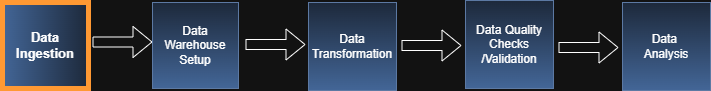

The first phase of the project involved the **ingestion of the Olist Kaggle dataset into Bigquery** , which was done using the following steps:
>  a) Create and Set Directory to Work In 
> <br> b) Set Up and Download Kaggle Token 
> <br> c) Configure Kaggle and Google Cloud
> <br> d) Set Up Key for Service Account in Google Cloud Storage 
> <br> e) Grant Storage Bucket Creation and Read Permission 
> <br> f) Create the Google Storage Bucket 
> <br> g) Download the Kaggle Dataset and Unzip Zipped Folder
> <br> h) Do some Data Cleaning and Validation
> <br> i) Upload the CSV Files to the Google Storage Bucket
> <br> j) Load the Files from Google Storage to BigQuery
> <br> k) Check that Number of Rows Tally Between Bigquery Tables and Local CSV Files

<u> **a) Create and Set Directory to Work In** </u>


In [2]:
import os
import pandas as pd
from IPython.display import display

# Set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# suppresses the SettingWithCopyWarning for all subsequent operations within the current Python session
pd.options.mode.chained_assignment = None

my_csv_files_directory = "<insert dir>"
problem_files__directory = "<insert dir>"
org_csv_files_from_source_directory  = "<insert dir>"
sql_tables_from_bigquery_directory = "<insert dir>"

# directory where files are downloaded to by default
download_directory = "<insert dir>""
kaggle_directory = "<insert dir>""

#create directory to store kaggle.json file
!mkdir -p {kaggle_directory}

#create directories to store downloaded csv files
!mkdir -p {my_csv_files_directory} #working csv files
!mkdir -p {org_csv_files_from_source_directory} #original csv files from source
!mkdir -p {problem_files__directory} #working files containing rows that failed check or were altered/removed
os.chdir(my_csv_files_directory)

<u> **b) Set Up and Download Kaggle Token** </u>

As the data resides in Kaggle, we decided to utilise the Kaggle CLI to facilitate the download of the dataset. 

To do so, a token (kaggle.json) was first created under "Settings" in Kaggle and then saved to download_directory (as defined earlier).


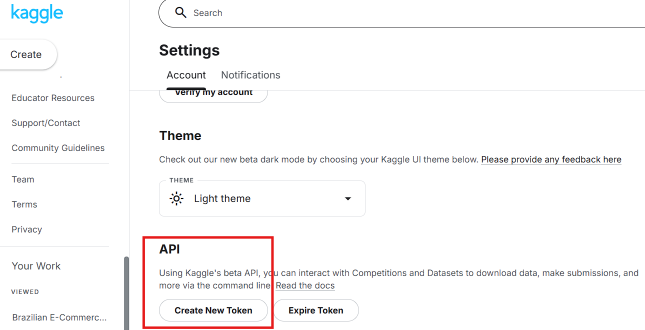

<u> **c) Configure Kaggle and Google Cloud** </u>

In [3]:
#!pip install kaggle

#Kaggle configurations
kaggle_data_path = "olistbr/brazilian-ecommerce" #info can be found on Kaggle
kaggle_data_set = "brazilian-ecommerce.zip"

#for uploading of csv files
#!pip install --upgrade google-cloud-bigquery google-cloud-storage

#for dl of sql tables
#!pip install sqlalchemy 
#!pip install db-dtypes
#!pip install google-cloud-bigquery-storage

from google.cloud import storage
from google.oauth2 import service_account
from google.api_core.exceptions import NotFound

#google cloud configurations
PROJECT_ID = "<insert>"
BUCKET_NAME = "<insert>" # must be globally unique
LOCATION = "us"  # or your desired region
prefix = "<insert>"  # Folder with CSV files on google storage
dataset_name = "<insert>"  # Desired dataset name in BigQuery



<u> **d) Set Up Key for Service Account in Google Cloud Storage** </u>

To facilitate the uploading of the CSV data to Google storage bucket, we needed the JSON key from the service account of the project used. 

Whilst we used back the token that was created for an earlier class, it is important to note that if this wasn't available, it would be necessary to set up the service account under the IAM page in Google Cloud, create and download the key accordingly into download_directory (as defined earlier).

In [3]:
#define key
SERVICE_ACCOUNT_FILE = f'{download_directory}/"<insert json file>"'


<u> **e) Grant Bucket Creation and Read Permission** </u>

Required permissions were added to allow for the creation of a cloud storage bucket for which the data will be stored and read access. The following commands were run:



In [ ]:
#add storage permission
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
  --member="serviceAccount:bigquery-admin@{PROJECT_ID}.iam.gserviceaccount.com" \
  --role="roles/storage.admin"


<u> **f) Create the Google Storage Bucket** </u>

A Google Storage Bucket was created by running the following commands:



In [132]:
from google.cloud import storage
from google.oauth2 import service_account
from google.api_core.exceptions import NotFound

#!gcloud auth activate-service-account bigquery-admin@rinniedsai.iam.gserviceaccount.com --key-file={download_directory}/'rinniedsai-7d2e1f39990d.json'
# --- Load credentials ---
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
client = storage.Client(credentials=credentials, project=PROJECT_ID)

# --- Check if bucket exists ---
try:
    bucket = client.get_bucket(BUCKET_NAME)
    print(f"⚠️ Bucket '{BUCKET_NAME}' already exists.")
except NotFound:
    # Create the bucket
    bucket = client.bucket(BUCKET_NAME)
    new_bucket = client.create_bucket(bucket, location=LOCATION)
    print(f"✅ Bucket '{BUCKET_NAME}' created in {new_bucket.location}")

  

⚠️ Bucket 'rinniedsai_brazilian_ecommerce' already exists.


<u> **g)  Download the Kaggle Dataset and Unzip Zipped Folder** </u>

The zipped file was downloaded via the Kaggle token and unzipped into the specified local directory by running the following commands:



In [76]:
# 1. Copy kaggle.json to kaggle_directory
!cp {download_directory}/kaggle.json {kaggle_directory}

# 2. Set permissions on kaggle.json
!chmod 600 {kaggle_directory}/kaggle.json

# 3. Download dataset using Kaggle CLI
#!kaggle datasets download {kaggle_data_path} -p {my_csv_files_directory}

# 4. Delete any existing .csv files in the target directory
!rm -f {my_csv_files_directory}/*.csv

# 5. Unzip the dataset into the target directory
!unzip -o {my_csv_files_directory}/brazilian-ecommerce.zip -d {my_csv_files_directory}

# 6. Copy CSV files to backup directory using shell command
!cp {my_csv_files_directory}/*.csv {org_csv_files_from_source_directory}/

# 7. Count and print number of CSV files
csv_files = [f for f in os.listdir(my_csv_files_directory) if f.endswith('.csv')]
print(f"Number of CSV files found and backed up: {len(csv_files)}")


Archive:  /home/rin/elt-project/test/csvfiles/brazilian-ecommerce.zip
  inflating: /home/rin/elt-project/test/csvfiles/olist_customers_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_geolocation_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_order_items_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_order_payments_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_order_reviews_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_orders_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_products_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/olist_sellers_dataset.csv  
  inflating: /home/rin/elt-project/test/csvfiles/product_category_name_translation.csv  
Number of CSV files found and backed up: 9


<u> **h) Do some Data Cleaning and Validation** </u>

Before uploading the data to Google Storage, some data cleaning and validation were performed as follows:

> 1) *olist_order_reviews_dataset.csv*: Put **double quotations for freeform text** in cells in the review_comment_title and review_comment_message columns
> 2) *all csvs*: **Trim** all string data,
> 3) *all csvs*: **Drop any duplicate rows** (i.e. rows that are exactly across all columns),
> 4) *all csvs*: **Check the first column for unique, non-null values**, as the first column looks likely to be the primary key, and
> 5) *olist_geolocation_dataset.csv* : Check that the **latitudes and longitudes are within the minimum and maximum latitudes and longitudes of Brazil**.
> 6) *all csvs*: Convert the data type to datetime for columns with names containing "date" or "timestamp" or "approved at".
     <br> Check that these columns have **dates that are between 2016 and 2018 inclusive**, since the dataaser is supposed to only contain 2016-2018 data.
     <br> Also check that if the csv file has 2 or more datetime columns, the **first datetime column contains the earliest date** amongst all datetime columns in the same file, and
>  7) *olist_orders_dataset.csv*: **Delivery date cannot be earlier than shipped date**. **Delivery date cannot be null if order status is marked as "delivered".**  
> 8) *all csvs*: Check that columns with names containing **"price" or "value" are non-negative**

Based on the results below, **steps 4 to 7 required further checks**.

<div class="alert alert-block alert-info">  Step 4: Four csv files (olist_order_reviews_dataset.csv, olist_order_payments_dataset.csv, olist_geolocation_dataset.csv and olist_order_items_dataset.csv) failed the first columnm non-unique check.
<br> Step 5: 27 rows from olist_geolocation_dataset.csv failed the lat/long check 
<br> Step 6: 4 rows from the olist_order_items_dataset.csv failed the year range check. 166 rows from the olist_orders_dataset.csv failed the earliest date check.
<br> Step 7: 23 and 8 rows from the olist_orders_dataset.csv failed delivery date cannot be earlier than shipping date test and the non-null delivery date for delivered orders test </div>

In [77]:
import pandas as pd
import os

def clean_csv_files_in_directory(my_csv_files_directory):
    files = [f for f in os.listdir(my_csv_files_directory) if f.endswith('.csv')]
    
    summary_data = []
    first_col_issues = {}
    earliest_date_issues = {}
    year_range_issues = {}
    negative_value_issues = {}
    geolocation_issues = {}

    # Latitude and Longitude boundaries for Brazil
    min_latitude = -33.75
    max_latitude = 5.27
    min_longitude = -73.99
    max_longitude = -29.35

    for file in files:
        file_path = os.path.join(my_csv_files_directory, file)
        df = pd.read_csv(file_path)

        # Process review comments for specific dataset
        if file == 'olist_order_reviews_dataset.csv':
            for col in ['review_comment_title', 'review_comment_message']:
                if col in df.columns:
                    df[col] = df[col].apply(lambda x: f'"{x}"' if pd.notnull(x) else x)

        # Strip whitespace from string columns
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].map(lambda x: x.strip() if isinstance(x, str) else x)

        rows_before = len(df)
        df_cleaned = df.drop_duplicates()
        rows_after = len(df_cleaned)

        # Convert date columns
        date_columns = [col for col in df_cleaned.columns if any(key in col.lower() for key in ['date', 'timestamp', 'approved_at'])]
        converted_columns = []
        for col in date_columns:
            try:
                df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')
                if pd.api.types.is_datetime64_any_dtype(df_cleaned[col]):
                    converted_columns.append(col)
            except:
                continue

        # Primary key sanity checks
        first_column = df_cleaned.columns[0]
        null_values = df_cleaned[first_column].isnull().sum()
        duplicate_values = df_cleaned[first_column].duplicated().sum()

        if null_values > 0 or duplicate_values > 0:
            prob_rows = df_cleaned[df_cleaned[first_column].isnull() | df_cleaned[first_column].duplicated(keep=False)]
            first_col_issues[file] = prob_rows
            prob_path = os.path.join(my_csv_files_directory, f"{file.replace('.csv', '')}_csv_problematic_rows.csv")
            prob_rows.to_csv(prob_path, index=False)

        # Geolocation Check
        geolocation_fail_count = 0
        if file == 'olist_geolocation_dataset.csv':
            if 'geolocation_lat' in df_cleaned.columns and 'geolocation_lng' in df_cleaned.columns:
                df_cleaned['geolocation_lat'] = pd.to_numeric(df_cleaned['geolocation_lat'], errors='coerce')
                df_cleaned['geolocation_lng'] = pd.to_numeric(df_cleaned['geolocation_lng'], errors='coerce')

                geolocation_fail_rows = df_cleaned[
                    (df_cleaned['geolocation_lat'] < min_latitude) | 
                    (df_cleaned['geolocation_lat'] > max_latitude) |
                    (df_cleaned['geolocation_lng'] < min_longitude) | 
                    (df_cleaned['geolocation_lng'] > max_longitude)
                ]
                geolocation_fail_count = geolocation_fail_rows.shape[0]

                if geolocation_fail_count > 0:
                    geolocation_issues[file] = geolocation_fail_rows
                    geolocation_fail_path = os.path.join(my_csv_files_directory, f"{file.replace('.csv', '')}_geolocation_failed_rows.csv")
                    geolocation_fail_rows.to_csv(geolocation_fail_path, index=False)

        # ✅ Negative Value Check (only for 'price' or 'value' columns)
        negative_value_fail_count = 0
        keyword_cols = [col for col in df_cleaned.columns 
                        if 'price' in col.lower() or 'value' in col.lower()]

        keyword_numeric_cols = [col for col in keyword_cols 
                                if pd.api.types.is_numeric_dtype(df_cleaned[col])]

        negative_fail_rows = pd.DataFrame()
        if keyword_numeric_cols:
            mask = (df_cleaned[keyword_numeric_cols] < 0).any(axis=1)
            negative_fail_rows = df_cleaned[mask]
            negative_value_fail_count = negative_fail_rows.shape[0]

        if negative_value_fail_count > 0:
            negative_value_issues[file] = negative_fail_rows
            negative_fail_path = os.path.join(my_csv_files_directory, f"{file.replace('.csv', '')}_negative_value_check_failed_rows.csv")
            negative_fail_rows.to_csv(negative_fail_path, index=False)

        # Earliest date check
        earliest_date_fail_count = 0
        earliest_date_failed_columns = []
        if len(converted_columns) >= 2:
            first_datetime_col = converted_columns[0]
            fail_rows = []
            column_fail_counts = {col: 0 for col in converted_columns[1:]}

            for idx, row in df_cleaned.iterrows():
                base = row[first_datetime_col]
                if pd.isnull(base):
                    continue
                for col in converted_columns[1:]:
                    if pd.notnull(row[col]) and row[col] < base:
                        column_fail_counts[col] += 1
                        fail_rows.append(row)
                        break

            earliest_date_failed_columns = [col for col, count in column_fail_counts.items() if count > 0]
            earliest_date_fail_count = sum(column_fail_counts.values())

            if fail_rows:
                fail_rows_df = pd.DataFrame(fail_rows)
                fail_rows_path = f"{my_csv_files_directory}/{file.replace('.csv', '')}_earliest_date_check_failed_rows.csv"
                fail_rows_df.to_csv(fail_rows_path, index=False)

        # Special logic for orders dataset
        order_delivered_customer_date_earlier_than_shipped_fail_count = 0
        order_delivered_customer_date_null_fail_count = 0
        if file == 'olist_orders_dataset.csv':
            if 'order_delivered_carrier_date' in df_cleaned.columns and 'order_delivered_customer_date' in df_cleaned.columns:
                df_cleaned['order_delivered_carrier_date'] = pd.to_datetime(df_cleaned['order_delivered_carrier_date'], errors='coerce')
                df_cleaned['order_delivered_customer_date'] = pd.to_datetime(df_cleaned['order_delivered_customer_date'], errors='coerce')

                failed_rows = df_cleaned[df_cleaned['order_delivered_customer_date'] < df_cleaned['order_delivered_carrier_date']]
                order_delivered_customer_date_earlier_than_shipped_fail_count = failed_rows.shape[0]

                if order_delivered_customer_date_earlier_than_shipped_fail_count > 0:
                    failed_rows_path = os.path.join(my_csv_files_directory, f"{file.replace('.csv', '')}_customer_delivery_earlier_than_shipped.csv")
                    failed_rows.to_csv(failed_rows_path, index=False)

                null_fail_rows = df_cleaned[
                    (df_cleaned['order_status'] == 'delivered') &
                    df_cleaned['order_delivered_customer_date'].isnull()
                ]
                order_delivered_customer_date_null_fail_count = null_fail_rows.shape[0]

                if order_delivered_customer_date_null_fail_count > 0:
                    null_fail_rows_path = os.path.join(my_csv_files_directory, f"{file.replace('.csv', '')}_customer_delivery_null_when_delivered.csv")
                    null_fail_rows.to_csv(null_fail_rows_path, index=False)

        # Summary row for current file
        summary_data.append({
            'File Name': file,
            'No. of Duplicate Rows': rows_before - rows_after,
            'Old Number of Rows': rows_before,
            'New Number of Rows': rows_after,
            'Number of Columns Converted to DateTime': len(converted_columns),
            'Columns Converted to DateTime': ', '.join(converted_columns),
            'Assumed Primary Key (First Column)': first_column,
            'Primary Key Test: First Column with Nulls': null_values,
            'Primary Key Test: First Column with Duplicates': duplicate_values,
            'Earliest Date Check Fail Count': earliest_date_fail_count,
            'Earliest Date Failed Columns': ', '.join(earliest_date_failed_columns),
            'Order Delivered Customer Date Earlier Than Shipped Fail Count': order_delivered_customer_date_earlier_than_shipped_fail_count,
            'Order Delivered Customer Date Null Fail Count': order_delivered_customer_date_null_fail_count,
            'Geolocation Check Fail Count': geolocation_fail_count,
            'Negative Value Test': negative_value_fail_count
        })

        # Save cleaned file
        df_cleaned.to_csv(file_path, index=False)

    # Display final summary
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print("📊 Summary Data")
        display(summary_df)
    else:
        print("No summary data to display!")

clean_csv_files_in_directory(my_csv_files_directory)


📊 Summary Data


,File Name,No. of Duplicate Rows,Old Number of Rows,New Number of Rows,Number of Columns Converted to DateTime,Columns Converted to DateTime,Assumed Primary Key (First Column),Primary Key Test: First Column with Nulls,Primary Key Test: First Column with Duplicates,Earliest Date Check Fail Count,Earliest Date Failed Columns,Order Delivered Customer Date Earlier Than Shipped Fail Count,Order Delivered Customer Date Null Fail Count,Geolocation Check Fail Count,Negative Value Test
0,olist_orders_dataset.csv,0,99441,99441,5,"order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",order_id,0,0,166,order_delivered_carrier_date,23,8,0,0
1,olist_sellers_dataset.csv,0,3095,3095,0,,seller_id,0,0,0,,0,0,0,0
2,olist_order_reviews_dataset.csv,0,99224,99224,2,"review_creation_date, review_answer_timestamp",review_id,0,814,0,,0,0,0,0
3,olist_order_payments_dataset.csv,0,103886,103886,0,,order_id,0,4446,0,,0,0,0,0
4,olist_geolocation_dataset.csv,261831,1000163,738332,0,,geolocation_zip_code_prefix,0,719317,0,,0,0,27,0
5,olist_products_dataset.csv,0,32951,32951,0,,product_id,0,0,0,,0,0,0,0
6,olist_customers_dataset.csv,0,99441,99441,0,,customer_id,0,0,0,,0,0,0,0
7,olist_order_items_dataset.csv,0,112650,112650,1,shipping_limit_date,order_id,0,13984,0,,0,0,0,0
8,product_category_name_translation.csv,0,71,71,0,,product_category_name,0,0,0,,0,0,0,0


### a) Primary Key Check
Looking at the output from  the cell above, there were **4 tables that contained duplicate values in their first respective first columns**. These required further investigation and the findings are summarised below. 



| # | Dataset                             | Number of Duplicate Values in First Column | Reason                                                                                                                                                                                                                                                                                                                         | Proposed Solution                                                                                        |
| - | ----------------------------------- | ------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------- |
| 1 | olist\_order\_reviews\_dataset.csv  | 814                                        | One `review_id` could have multiple `order_id`s, which does not seem to make sense. In this dataset `order_id` also cannot be primary key as one `order_id` can have mulitple `review_id`s i.e. there are duplicate values for `order_id`. See example below.  | Remove duplicate `review_id` rows by attempting to tag each review to the correct `order_id`.            |
| 2 | olist\_order\_payments\_dataset.csv | 4,446                                      | One `order_id` can have multiple `payment_sequential` values because a customer may pay using multiple payment methods, creating a sequence for each payment.                                                                                                                                                                  | Create a composite primary key combining `order_id` and `payment_sequential`. Then aggregate `payment_value` by `order_id`                           |
| 3 | olist\_geolocation\_dataset.csv     | 719,317                                    | One 5-digit zip code can correspond to multiple similar latitude/longitude coordinates. Brazilian zip codes are 8 digits, but `geolocation_zip_code_prefix` contains only 5-digit zip codes, which represent broader areas. The detailed 8-digit codes may have been masked for confidentiality, as a more granular zipcodes could lead to the identification of the customer or seller. (Zipocdes in the customer and seller datasets are also 5-digit. Hence, this could explain why                                                              | For analysis, keep only the first row for each repeated zip code, as approximate location is sufficient. |
| 4 | olist\_order\_items\_dataset.csv    | 13,984                                     | One `order_id` can have multiple `order_item_id`.   The latter is a sequential number identifying number of items included in the same order.                                                                                                                                                                                                                                                                                                   | Create a composite primary key combining `order_id` and `order_item_id`. Then  aggregate `price` by order_id                        |                                    |



<div class="alert alert-block alert-info"> 
olist_order_reviews_dataset.csv: An example when one order_id can have multiple review_ids. 

It appears that a different review was done for each of the items in the order that arrived at different timings despite being ordered together.
</div>

| review_id                           | order_id                           | review_score | review_comment_message                                                                                                                                               | English Translation                                                                                                                   |
|-------------------------------------|------------------------------------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------|
| b04ed893318da5b863e878cd3d0511df    | 03c939fd7fd3b38f8485a0f95798f1f6  | 3            | "Um ponto negativo que achei foi a cobrança de 3 taxas de entregas, sendo que comprei os 3 produtos iguais numa só compra. E mesmo comprando os produtos juntos, chegaram separados." | "A negative point I found was the charging of 3 delivery fees, even though I bought the 3 identical products in a single purchase. And even though I bought the products together, they arrived separately." |
| f4bb9d6dd4fb6dcc2298f0e7b17b8e1e    | 03c939fd7fd3b38f8485a0f95798f1f6  | 4            |                                                                                                                                                                      |                                                                                                                                        |
| 405eb2ea45e1dbe2662541ae5b47e2aa    | 03c939fd7fd3b38f8485a0f95798f1f6  | 3            | "Seria ótimo se tivessem entregue os 3 (três) pedidos de uma única vez."                                                                                             | "It would have been great if they had delivered all 3 (three) orders at once."                                                        |


<div class="alert alert-block alert-info">  olist_order_reviews_dataset.csv: To see how duplicate `review_id`s could be removed from the olist_order_reviews_dataset.csv, the csv file was merged with the data from the olist_orders_dataset.csv using `order_id` as the key. 


The difference between the review_creation_date and the delivery date (earlier of `'order_delivered_customer_date` and `order_estimated_delivery_date`). </div> The output showed that most of the reviews (~95k out of ~99k reviews) were **created within 2 days of the delivery date**. Hence, we can use this as a criterion to remove rows with duplicate `review_ids` and reviews were created **more than 2 days after product was delivered, i.e. if it was more than 2 days, then the review is assumed to be not tagged to the correct order_id** and thus removed. If duplicate review_ids still remain, then these rows are dropped as there is no other way to make a good assumption as to which order ID it can be tagged to. 1114 rows were eventually dropped (1.12% of the orginal reviews dataset.

### ai) Difference between Review Creation Date and Delivery Date

In [71]:
# Load CSVs
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')

# Convert relevant columns to datetime
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'], errors='coerce')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], errors='coerce')
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'], errors='coerce')

# Left join on order_id
df = pd.merge(df_reviews, df_orders, on='order_id', how='left')

# Create new column with earlier date between delivered and estimated delivery
df['earlier_delivery_date'] = df[['order_delivered_customer_date', 'order_estimated_delivery_date']].min(axis=1)

# Convert earlier_delivery_date back to datetime for subtraction
df['earlier_delivery_date'] = pd.to_datetime(df['earlier_delivery_date'])

# Calculate difference in days between review_creation_date and earlier_delivery_date
df['review_to_earlier_delivery_days'] = (df['review_creation_date'] - df['earlier_delivery_date']).dt.days

# Value counts for the difference
counts = df['review_to_earlier_delivery_days'].value_counts()
print(counts)



review_to_earlier_delivery_days
 0     83469
 2      6660
 1      2569
-1      2564
 3      1297
       ...  
-53        1
 56        1
 45        1
 44        1
-37        1
Name: count, Length: 109, dtype: int64


### aii) Removal of Duplicate Review IDs so that Review ID can now be Primary Key



In [72]:
# Preserve original row count
original_row_count = len(df)

# Step 1: Mark duplicated review_ids
df['Dup_Review_ID'] = df.duplicated('review_id', keep=False).map({True: 'Y', False: 'N'})

# Step 2: Ensure 'review_to_earlier_delivery_days' is numeric
if 'review_to_earlier_delivery_days' not in df.columns:
    raise ValueError("Column 'review_to_earlier_delivery_days' not found in DataFrame.")

df['review_to_earlier_delivery_days'] = pd.to_numeric(df['review_to_earlier_delivery_days'], errors='coerce')

# Step 3: Identify and remove invalid duplicate rows
to_drop_condition_1 = (df['Dup_Review_ID'] == 'Y') & (~df['review_to_earlier_delivery_days'].isin([0, 1, 2]))
df_remaining = df[~to_drop_condition_1]

# Step 4: Drop remaining duplicate review_ids
to_drop_condition_2 = df_remaining.duplicated('review_id', keep=False)
df_cleaned = df_remaining[~to_drop_condition_2]

# Step 5: Combine all dropped rows
dropped_rows = pd.concat([
    df[to_drop_condition_1],
    df_remaining[to_drop_condition_2]
])
dropped_rows.to_csv('dropped_reviews.csv', index=False)

# Step 6: Print stats
num_dropped = len(dropped_rows)
percent_dropped = (num_dropped / original_row_count) * 100
new_row_count = len(df_cleaned)

print(f"🗑️ Total rows dropped: {num_dropped} ({percent_dropped:.2f}%)")
print(f"📊 Rows remaining after cleaning: {new_row_count}")

# Step 7: Final check
assert df_cleaned['review_id'].is_unique, "❌ review_id is still not unique!"

# Step 8: Drop unnecessary columns
columns_to_drop = [
    'order_approved_at', 
    'review_to_earlier_delivery_days',
    'Dup_Review_ID'
]
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns], errors='ignore')

# Step 9: Save cleaned file
df_cleaned.to_csv('olist_order_reviews_dataset_cleaned.csv', index=False)
print("✅ Cleaned dataset saved as 'olist_order_reviews_dataset_cleaned.csv'")


🗑️ Total rows dropped: 1114 (1.12%)
📊 Rows remaining after cleaning: 98110
✅ Cleaned dataset saved as 'olist_order_reviews_dataset_cleaned.csv'


<div class="alert alert-block alert-info"> olist_geolocation_dataset.csv: Only the first row for each repeated zip code was kept , so geolocation_zip_code_prefix can be the primary key for this file. In addition, there were 27 rows that failed the longitude/latitude checks. These rows were also removed from the dataset.  </div>

In [73]:

# Load the geolocation dataset
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')

# Latitude and Longitude boundaries for Brazil
min_latitude = -33.75
max_latitude = 5.27
min_longitude = -73.99
max_longitude = -29.35  # Easternmost point of Brazil (including islands)

# Condition to keep only rows that pass the latitude and longitude test
valid_geolocation = (
    (df_geolocation['geolocation_lat'] >= min_latitude) & 
    (df_geolocation['geolocation_lat'] <= max_latitude) & 
    (df_geolocation['geolocation_lng'] >= min_longitude) & 
    (df_geolocation['geolocation_lng'] <= max_longitude)
)

# Get the valid rows (those that pass the test)
df_geolocation_cleaned = df_geolocation[valid_geolocation]

# Get the failed rows (those that did not pass the test)
df_geolocation_failed = df_geolocation[~valid_geolocation]

# Print the number of failed rows
failed_row_count = df_geolocation_failed.shape[0]
print(f"Number of rows that failed the geolocation test: {failed_row_count}")

# Optionally, you can save the failed rows to a separate file for further inspection
df_geolocation_failed.to_csv('olist_geolocation_failed_rows.csv', index=False)

# Sort the cleaned data by 'geolocation_zip_code_prefix' and 'geolocation_lat'
df_geolocation_sorted = df_geolocation_cleaned.sort_values(by=['geolocation_zip_code_prefix', 'geolocation_lat'])

# Drop duplicates based on 'geolocation_zip_code_prefix' and keep the first row
df_geolocation_cleaned = df_geolocation_sorted.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')

# Save the cleaned geolocation dataset
df_geolocation_cleaned.to_csv('olist_geolocation_dataset_cleaned.csv', index=False)

print("Cleaned Geolocation Dataset:")
display(df_geolocation_cleaned.head())  # Optionally display the first few rows of the cleaned data



Number of rows that failed the geolocation test: 27
Cleaned Geolocation Dataset:


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
250,1001,-23.551427,-46.634074,sao paulo,SP
464,1002,-23.548878,-46.634004,sao paulo,SP
341,1003,-23.549083,-46.634864,são paulo,SP
326,1004,-23.550765,-46.635323,sao paulo,SP
399,1005,-23.549980,-46.634768,são paulo,SP


<div class="alert alert-block alert-info"> olist_order_payments_dataset.csv: Create a composite primary key combining order_id and payment_sequential. Then aggregate payment_value by order_id.
    
<br> olist_order_items_dataset.csv: Create a composite primary key combining order_id and order_item_id. Then aggregate price by order_id </div>


In [ ]:

# Load datasets
payments_df = pd.read_csv("olist_order_payments_dataset.csv")
items_df = pd.read_csv("olist_order_items_dataset.csv")

# ----------------------------------------
# Payments Dataset
# ----------------------------------------

# Composite key
payments_df["orderid_paymentseq_composite_key"] = payments_df["order_id"].astype(str) + "_" + payments_df["payment_sequential"].astype(str)

# Window function: total payment_value per order_id
payments_df["total_payment_value"] = payments_df.groupby("order_id")["payment_value"].transform("sum")

# Show only duplicate order_id values
dup_order_ids_payments = payments_df[payments_df.duplicated(subset=["order_id"], keep=False)]

print("🔁 Payment Rows with Duplicate order_id Values (Check Aggregation):")
display(dup_order_ids_payments.sort_values(["order_id", "payment_sequential"]))

# Save entire payments dataframe with added columns
payments_df.to_csv("olist_order_payments_dataset_cleaned.csv", index=False)

# ----------------------------------------
# Items Dataset
# ----------------------------------------

# Composite key
items_df["orderid_orderitemid_composite_key"] = items_df["order_id"].astype(str) + "_" + items_df["order_item_id"].astype(str)

# Window functions:
items_df["total_price"] = items_df.groupby("order_id")["price"].transform("sum")
items_df["total_freight_value"] = items_df.groupby("order_id")["freight_value"].transform("sum")

# Show only duplicate order_id values
dup_order_ids_items = items_df[items_df.duplicated(subset=["order_id"], keep=False)]

print("\n🔁 Items Rows with Duplicate order_id Values (Check Aggregation):")
display(dup_order_ids_items.sort_values(["order_id", "order_item_id"]))

# Save entire items dataframe with added columns
items_df.to_csv("olist_order_items_dataset_cleaned.csv", index=False)


### b) Earliest Date Check, Order Delivered Date Not Earlier Than Shipped Date Check, Delivery Date Not Null for Delivered Orders Check

166 rows in the failed this check in **olist_orders_dataset.csv** and they were all caused by the column `order_delivered_carrier_date`. The latter refers to the order posting timestamp, when it was handled to the logistic partner. Hence, it should not be earlier than the `order_purchase_timestamp`.

Looking at the 1st histogram, the difference between the 2 timestamps is very small most of the time. But given that in reality it seems almost impossible to hand the goods almost immediately to the logistics partner, all these `order_delivered_carrier_date` will be made null and the rows with the original carrier dates will be saved in a separate csv file for record purposes. A total of 166 rows would be changed.

Looking at the 2nd histogram, this seems to affirm that  `order_delivered_carrier_date` is problematic, as it also doesn't make sense for the shipping date to be later than the delivery date. So these dates will be made null and the rows with the original carrier dates will be saved in a separate csv file for record purposes.  A total of 23 rows would be changed. 

For the 7 rows with null deliveries despite orders being delivered, we will add a new column to indicate the delivery date was indeed missing from the original dataset.

### bi) Plotting the distribution

Delivery delay (days) range:
Min: 0.0002777777777777778
Max: 171.21241898148148
Mean: 1.0849782463186075


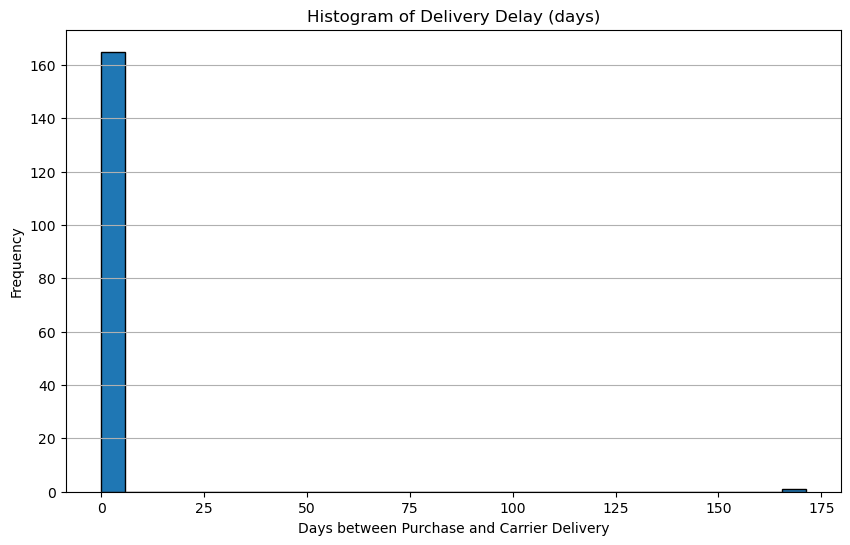

In [76]:
import matplotlib.pyplot as plt
os.chdir(my_csv_files_directory)

# Load the CSV
file_path = 'olist_orders_dataset_earliest_date_check_failed_rows.csv'
df = pd.read_csv(file_path)

# Convert columns containing "date" or "timestamp" to datetime
date_cols = [col for col in df.columns if 'date' in col.lower() or 'timestamp' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create a new column for difference (in days) between order_purchase_timestamp and order_delivered_carrier_date
df['no_of_days_earlier'] = (df['order_purchase_timestamp'] - df['order_delivered_carrier_date']).dt.total_seconds() / (24 * 3600)

# Show basic info about the new column
print("Delivery delay (days) range:")
print(f"Min: {df['no_of_days_earlier'].min()}")
print(f"Max: {df['no_of_days_earlier'].max()}")
print(f"Mean: {df['no_of_days_earlier'].mean()}")

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df['no_of_days_earlier'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of Delivery Delay (days)')
plt.xlabel('Days between Purchase and Carrier Delivery')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()



Difference:
Min: -178.27065972222223
Max: -0.8947916666666667
Mean: -8.436785143097644


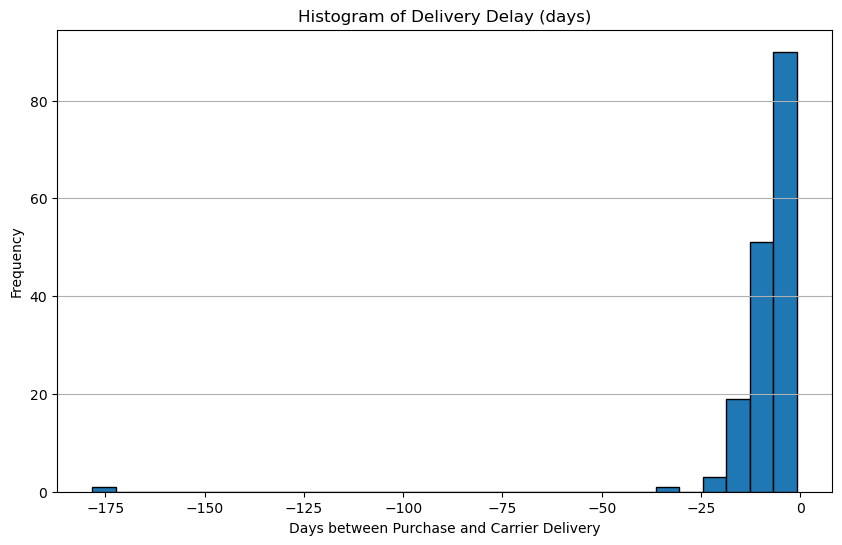

In [78]:
file_path = 'olist_orders_dataset_order_delivered_customer_date_earlier_than_shipped_failed.csv'
# Convert columns containing "date" or "timestamp" to datetime
date_cols = [col for col in df.columns if 'date' in col.lower() or 'timestamp' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create a new column for difference (in days) between order_purchase_timestamp and order_delivered_carrier_date
df['no_of_days_earlier'] = (df['order_delivered_carrier_date'] - df['order_delivered_customer_date']).dt.total_seconds() / (24 * 3600)

# Show basic info about the new column
print("Difference:")
print(f"Min: {df['no_of_days_earlier'].min()}")
print(f"Max: {df['no_of_days_earlier'].max()}")
print(f"Mean: {df['no_of_days_earlier'].mean()}")

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df['no_of_days_earlier'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of Delivery Delay (days)')
plt.xlabel('Days between Purchase and Carrier Delivery')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

### bii) replacing with NULL for problematic rows and adding a new indicator "missing_delivery_date_for_delivered_orders"

In [83]:
import pandas as pd

# Load dataset
file_path = "olist_orders_dataset.csv"
df = pd.read_csv(file_path)

# Convert to datetime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors='coerce')
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"], errors='coerce')
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"], errors='coerce')

# Create flag column for invalid carrier delivery dates
df["invalid_carrier_delivery"] = (
    (df["order_delivered_carrier_date"] < df["order_purchase_timestamp"]) |
    (df["order_delivered_customer_date"] < df["order_delivered_carrier_date"])
)
df["invalid_carrier_delivery"] = df["invalid_carrier_delivery"].apply(lambda x: "Y" if x else "N")

# Create missing delivery date indicator for delivered orders
df["missing_delivery_date_for_delivered_orders"] = (
    (df["order_status"] == 'delivered') & df["order_delivered_customer_date"].isnull()
)
df["missing_delivery_date_for_delivered_orders"] = df["missing_delivery_date_for_delivered_orders"].apply(lambda x: "Y" if x else "N")

# Extract invalid rows
invalid_rows = df[df["invalid_carrier_delivery"] == "Y"]

# Save invalid rows to a CSV
invalid_rows.to_csv("orders_with_invalid_delivery_dates.csv", index=False)

# Make order_delivered_carrier_date NULL (NaT) for invalid rows
df.loc[df["invalid_carrier_delivery"] == "Y", "order_delivered_carrier_date"] = pd.NaT

# Save modified dataset
df.to_csv("olist_orders_dataset_cleaned.csv", index=False)

# Print stats
invalid_count = len(invalid_rows)
total_count = len(df)
percent = (invalid_count / total_count) * 100

print(f"❌ Rows with invalid carrier delivery dates made NULL: {invalid_count}")
print(f"📊 As percentage of total: {percent:.2f}%")


❌ Rows with invalid carrier delivery dates made NULL: 189
📊 As percentage of total: 0.19%


### c) Year Range Check

A total of 4 rows failed the year range check in `shipping_limit_date' from olist_order_items_dataset.csv. Looking at the data, even though these dates were after 2018, it may be still reasonable to assume that these dates are as such since this just refers to the shipping limit date for handing the order over to the logistic partner. Hence, no change was made to this file.

| order_id                           | order_item_id | product_id                        | seller_id                          | shipping_limit_date | price | freight_value |
|------------------------------------|---------------|-----------------------------------|------------------------------------|----------------------|-------|----------------|
| 13bdf405f961a6deec817d817f5c6624   | 1             | 96ea060e41bdecc64e2de00b97068975 | 7a241947449cc45dbfda4f9d0798d9d0   | 2/5/2020 3:30        | 69.99 | 14.66          |
| 9c94a4ea2f7876660fa6f1b59b69c8e6   | 1             | 282b126b2354516c5f400154398f616d | 7a241947449cc45dbfda4f9d0798d9d0   | 2/3/2020 20:23       | 75.99 | 14.7           |
| c2bb89b5c1dd978d507284be78a04cb2   | 1             | 87b92e06b320e803d334ac23966c80b1 | 7a241947449cc45dbfda4f9d0798d9d0   | 4/9/2020 22:35       | 99.99 | 61.44          |
| c2bb89b5c1dd978d507284be78a04cb2   | 2             | 87b92e06b320e803d334ac23966c80b1 | 7a241947449cc45dbfda4f9d0798d9d0   | 4/9/2020 22:35       | 99.99 | 61.44          |


<u> **i) Upload the CSV Files to the Google Storage Bucket** </u>

Unwanted csv files were either moved to another directoty or deleted. 

The remaining csv files were uploaded onto Google Storage Bucket using gsutil:


In [ ]:
def move_problematic_csvs(source_dir, destination_dir):
    # Create destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Define keywords to identify problematic files
    keywords = ['failed', 'invalid', 'problematic', 'dropped', 'earlier', 'null']

    # List all CSV files
    files = [f for f in os.listdir(source_dir) if f.endswith('.csv')]

    # Move files containing any of the keywords
    moved_files = []
    for file in files:
        if any(keyword in file.lower() for keyword in keywords):
            source_path = os.path.join(source_dir, file)
            destination_path = os.path.join(destination_dir, file)
            os.rename(source_path, destination_path)
            moved_files.append(file)

    # Print results
    if moved_files:
        print(f"✅ Moved {len(moved_files)} file(s):")
        for f in moved_files:
            print(f"  - {f}")
    else:
        print("ℹ️ No matching files found to move.")


move_problematic_csvs(my_csv_files_directory, problem_files__directory)


In [85]:
def delete_unclean_versions(csv_directory):
    # List all CSV files in the directory
    all_csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]
    
    # Find cleaned versions
    cleaned_files = {f.replace('_cleaned.csv', '') for f in all_csv_files if '_cleaned.csv' in f}

    deleted_files = []
    for file in all_csv_files:
        if file.endswith('_cleaned.csv'):
            continue  # Skip cleaned versions themselves
        
        base_name = file.replace('.csv', '')
        if base_name in cleaned_files:
            file_to_delete = os.path.join(csv_directory, file)
            os.remove(file_to_delete)
            deleted_files.append(file)

    # Report
    if deleted_files:
        print(f"🗑️ Deleted {len(deleted_files)} uncleaned file(s):")
        for f in deleted_files:
            print(f"  - {f}")
    else:
        print("✅ No uncleaned files found to delete.")

# Example usage:
delete_unclean_versions(my_csv_files_directory)


🗑️ Deleted 5 uncleaned file(s):
  - olist_orders_dataset.csv
  - olist_order_reviews_dataset.csv
  - olist_order_payments_dataset.csv
  - olist_geolocation_dataset.csv
  - olist_order_items_dataset.csv


In [87]:
def count_csv_rows(my_csv_files_directory):
    csv_files = [f for f in os.listdir(my_csv_files_directory) if f.endswith('.csv')]
    if not csv_files:
        print("📁 No CSV files found in the directory.")
        return

    print(f"{'File Name':<50} | {'Row Count'}")
    print("-" * 65)

    for file in sorted(csv_files):
        file_path = os.path.join(my_csv_files_directory, file)
        try:
            df = pd.read_csv(file_path)
            print(f"{file:<50} | {len(df):>9}")
        except Exception as e:
            print(f"{file:<50} | Error reading file: {e}")

count_csv_rows(my_csv_files_directory)


File Name                                          | Row Count
-----------------------------------------------------------------
olist_customers_dataset.csv                        |     99441
olist_geolocation_dataset_cleaned.csv              |     19011
olist_order_items_dataset_cleaned.csv              |    112650
olist_order_payments_dataset_cleaned.csv           |    103886
olist_order_reviews_dataset_cleaned.csv            |     98110
olist_orders_dataset_cleaned.csv                   |     99441
olist_products_dataset.csv                         |     32951
olist_sellers_dataset.csv                          |      3095
product_category_name_translation.csv              |        71


In [88]:
#upload csv files
!gsutil -m cp {my_csv_files_directory}/*.csv gs://{BUCKET_NAME}/

#show file directory in google storage to check
!gsutil ls gs://{BUCKET_NAME}/


Copying file:///home/rin/elt-project/test/csvfiles/olist_customers_dataset.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_geolocation_dataset_cleaned.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_order_items_dataset_cleaned.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_order_payments_dataset_cleaned.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_order_reviews_dataset_cleaned.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_orders_dataset_cleaned.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_products_dataset.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/olist_sellers_dataset.csv [Content-Type=text/csv]...
Copying file:///home/rin/elt-project/test/csvfiles/product_category_name_translation.csv [Content-Type=te

**j) Load the Files from Google Storage to BigQuery**

In [89]:
from google.cloud import bigquery, storage

# Initialize clients
bq_client = bigquery.Client()
storage_client = storage.Client()

# Parameters
prefix = ''  # Folder with CSV files

# Full dataset ID
dataset_id = f"{PROJECT_ID}.{dataset_name}"

# 1. Create dataset if it does not exist
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"  # Set your region

dataset = bq_client.create_dataset(dataset, exists_ok=True)
print(f"Dataset '{dataset_id}' created or already exists.")

# 2. List CSV files in the bucket root
bucket = storage_client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs(prefix=prefix)

# 3. Load each CSV into its own table
for blob in blobs:
    if blob.name.endswith('.csv'):
        gcs_uri = f'gs://{BUCKET_NAME}/{blob.name}'
        filename = blob.name.split('/')[-1]
        table_name = filename.replace('.csv', '')
        table_ref = bq_client.dataset(dataset_name).table(table_name)

        # Job configuration
        job_config = bigquery.LoadJobConfig(
            source_format=bigquery.SourceFormat.CSV,
            skip_leading_rows=1,  # Skip header row
            autodetect=True,  # Auto-detect schema
            write_disposition=bigquery.WriteDisposition.WRITE_APPEND,  # Append to existing table
             allow_quoted_newlines=True,  
            max_bad_records=1000000,  # Allow up to 1 million bad records (adjust as necessary)
            ignore_unknown_values=True  # Ignore extra unknown columns
        )

        print(f'Loading {gcs_uri} into {dataset_name}.{table_name}...')
        
        # Start the load job
        load_job = bq_client.load_table_from_uri(
            gcs_uri,
            table_ref,
            job_config=job_config
        )
        
        # Wait for the job to complete
        load_job.result()
        
        print(f'✅ Loaded {load_job.output_rows} rows into {dataset_name}.{table_name}')


Dataset 'rinniedsai.brazil_ecommerce' created or already exists.
Loading gs://rinniedsai_brazilian_ecommerce/olist_customers_dataset.csv into brazil_ecommerce.olist_customers_dataset...
✅ Loaded 99441 rows into brazil_ecommerce.olist_customers_dataset
Loading gs://rinniedsai_brazilian_ecommerce/olist_geolocation_dataset_cleaned.csv into brazil_ecommerce.olist_geolocation_dataset_cleaned...
✅ Loaded 19011 rows into brazil_ecommerce.olist_geolocation_dataset_cleaned
Loading gs://rinniedsai_brazilian_ecommerce/olist_order_items_dataset_cleaned.csv into brazil_ecommerce.olist_order_items_dataset_cleaned...
✅ Loaded 112650 rows into brazil_ecommerce.olist_order_items_dataset_cleaned
Loading gs://rinniedsai_brazilian_ecommerce/olist_order_payments_dataset_cleaned.csv into brazil_ecommerce.olist_order_payments_dataset_cleaned...
✅ Loaded 103886 rows into brazil_ecommerce.olist_order_payments_dataset_cleaned
Loading gs://rinniedsai_brazilian_ecommerce/olist_order_reviews_dataset_cleaned.csv in

**k) Check that Number of Rows Tally Between Bigquery Tables and Local CSV Files**

In [90]:
# --- Configuration ---
project_id = PROJECT_ID
dataset_id = dataset_name
local_directory = my_csv_files_directory

# --- Initialize BigQuery Client ---
client = bigquery.Client(project=project_id)

# --- Function to count rows in a BigQuery table ---
def get_bq_row_count(table_id):
    query = f"SELECT COUNT(*) as row_count FROM `{project_id}.{dataset_id}.{table_id}`"
    query_job = client.query(query)
    return list(query_job.result())[0].row_count

# --- Comparison ---
results = []

for file in os.listdir(local_directory):
    if file.endswith(".csv"):
        local_path = os.path.join(local_directory, file)

        try:
            # Load local CSV into DataFrame
            df_local = pd.read_csv(local_path)
            local_row_count = len(df_local)
        except Exception as e:
            local_row_count = "⚠️ Error reading CSV"
            df_local = None

        # BigQuery table name (remove .csv)
        table_name = file.replace(".csv", "")

        try:
            bq_row_count = get_bq_row_count(table_name)
        except Exception as e:
            bq_row_count = "⚠️ Error querying BQ"

        # Match or not?
        if isinstance(local_row_count, int) and isinstance(bq_row_count, int):
            status = "✅ Match" if local_row_count == bq_row_count else "❌ Mismatch"
        else:
            status = "⚠️ Error"

        results.append({
            "CSV File": file,
            "Local Row Count": local_row_count,
            "BigQuery Table": table_name,
            "BigQuery Row Count": bq_row_count,
            "Status": status
        })

# --- Display Summary ---
summary_df = pd.DataFrame(results)
print(summary_df.to_string(index=False))


                                CSV File  Local Row Count                       BigQuery Table  BigQuery Row Count  Status
   olist_order_items_dataset_cleaned.csv           112650    olist_order_items_dataset_cleaned              112650 ✅ Match
               olist_sellers_dataset.csv             3095                olist_sellers_dataset                3095 ✅ Match
              olist_products_dataset.csv            32951               olist_products_dataset               32951 ✅ Match
             olist_customers_dataset.csv            99441              olist_customers_dataset               99441 ✅ Match
olist_order_payments_dataset_cleaned.csv           103886 olist_order_payments_dataset_cleaned              103886 ✅ Match
   olist_geolocation_dataset_cleaned.csv            19011    olist_geolocation_dataset_cleaned               19011 ✅ Match
        olist_orders_dataset_cleaned.csv            99441         olist_orders_dataset_cleaned               99441 ✅ Match
   product_categ